In [46]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from implementations import *
from proj1_helpers import *
from misc_helpers import *
from plot_functions import *
from ml_math import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [54]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)


In [55]:
#check datas and balance of the class
N, p = np.shape(tX)
print(np.shape(tX))
print(len(y[y==1.]))
print(len(y[y==-1.]))

(250000, 30)
85667
164333


In [57]:
tX[y==1.,:]

array([[ 1.38470e+02,  5.16550e+01,  9.78270e+01, ...,  1.24000e+00,
        -2.47500e+00,  1.13497e+02],
       [ 1.48754e+02,  2.88620e+01,  1.07782e+02, ...,  1.31000e-01,
        -2.76700e+00,  1.79877e+02],
       [ 1.54916e+02,  1.04180e+01,  9.47140e+01, ..., -9.99000e+02,
        -9.99000e+02,  3.06380e+01],
       ...,
       [ 1.33457e+02,  7.75400e+01,  8.89890e+01, ..., -9.99000e+02,
        -9.99000e+02,  7.09690e+01],
       [ 1.30075e+02,  3.91800e+00,  6.67810e+01, ...,  5.78000e-01,
        -2.21500e+00,  5.46066e+02],
       [ 1.05457e+02,  6.05260e+01,  7.58390e+01, ..., -9.99000e+02,
        -9.99000e+02,  4.19920e+01]])

In [58]:
#Over sample
y1 = y[y==1.]
X1 = tX[y==1.,:]
y = np.append(y,y1)
tX = np.append(tX,X1,axis=0)
print(np.shape(tX))
print(len(y[y==1.]))
print(len(y[y==-1.]))

(335667, 30)
171334
164333


In [59]:
#change y
y = (y+1)/2
# normalize X
tX = normalize(tX)

## Do your crazy machine learning thing here :) ...

In [60]:
def split_data(y, x, ratio, myseed=1):
    """split the dataset based on the split ratio."""
    # set seed
    np.random.seed(myseed)
    # generate random indices
    num_row = len(y)
    indices = np.random.permutation(num_row)
    index_split = int(np.floor(ratio * num_row))
    index_tr = indices[: index_split]
    index_te = indices[index_split:]
    # create split
    x_tr = x[index_tr]
    x_te = x[index_te]
    y_tr = y[index_tr]
    y_te = y[index_te]
    return x_tr, x_te, y_tr, y_te

In [61]:
ratio = 0.8
x_train, x_test, y_train, y_test = split_data(y, tX, ratio)

## Logistic regression function

In [136]:
from numpy.random import randint
def sigmoid(t):
    """apply sigmoid function on t."""
    return 1.0 / (1.0+np.exp(-t))

def calculate_loss(y, tx, w):
    """compute the cost by negative log likelihood."""
    s = 0
    for n in range(len(y)):
        s += np.log(1 + np.exp(np.dot(tx[n,:].T,w))) - y[n]*np.dot(tx[n,:].T,w)
    return s 

def calculate_gradient(y, tx, w):
    """compute the gradient of loss."""
    return np.dot(tx.T,sigmoid(np.dot(tx,w))-y)

def calculate_hessian(y, tx, w):
    """return the hessian of the loss function."""
    N = len(y)
    S = np.eye(N)
    for n in range(N):
        pred = sigmoid(np.dot(tx[n,:].T,w))
        S[n,n] = pred*(1-pred)
    return tx.T.dot(S.dot(tx))

def logistic_regression(y, tx, w, newton = False):
    """return the loss, gradient, and hessian."""
    loss = calculate_loss(y, tx, w)
    gradient = calculate_gradient(y, tx, w)
    if newton:
        hess = calculate_hessian(y, tx, w)
    else:
        hess = 0
    return loss, gradient, hess

def penalized_logistic_regression(y, tx, w, lambda_, newton = False):
    """return the loss, gradient, and hessian."""
    loss, gradient, hess = logistic_regression(y, tx, w, newton)
    loss += lambda_/2*np.linalg.norm(w)**2
    gradient += lambda_*w
    if newton:
        hess += lambda_*np.eye(len(w)).dot(w)
    else:
        hess = 0
    return loss, gradient, hess

def logistic_regression_ADAM(y , tx, lambda_, maxit, w0, verbose = False):
    """return w using ADAM"""
    n , p =np.shape(tx)
    w = w0
    w_prev = w
    alpha = 0.1
    beta1 = 0.9
    beta2 = 0.999
    eps = 1E-8
    m_prev = 0
    v_prev = 0
    for k in range(maxit):
        g = calculate_gradient(y, tx, w_prev) + lambda_ * w
        m = beta1*m_prev + (1-beta1)*g
        v = beta2*v_prev + (1-beta2)*g**2
        m_hat = m/(1-beta1)
        v_hat = v/(1-beta2)
        H = np.sqrt(v_hat)+eps
        w_next = w - alpha*m_hat/H
        w_prev = w
        w = w_next
        m_prev = m
        v_prev = v
        #loss = calculate_loss(y, tx, w)
        #if not k%10 and verbose:
        #if verbose:
            #print ('%d : loss = %f, norm(g) = %f'%(k,loss,np.linalg.norm(w)) )
            #print(k)
    return w

def logistic_regression_GD(y , tx, gamma, lambda_, maxit, verbose = False):
    """return w using ADAM"""
    n , p =np.shape(tx)
    w = np.zeros(p)
    
    for k in range(maxit):
        g = calculate_gradient(y, tx, w) + lambda_ * w
        w = w - gamma*g
        
        #loss = calculate_loss(y, tx, w)
        #if not k%10 and verbose:
        if verbose:
            #print ('%d : loss = %f, norm(g) = %f'%(k,loss,np.linalg.norm(w)) )
            print(k)
    return w

def logistic_regression_SGD(y , tx, lambda_, maxit, verbose = False):
    """return w using ADAM"""
    n , p =np.shape(tx)
    w = np.zeros(p)
    
    for k in range(maxit):
        i = randint(0,n),
        alpha = (n/2)/(k+(n/2))
        g = calculate_gradient(y[i], tx[i,:], w) + lambda_ * w
        w = w - alpha * g
        
        #if not k%100 and verbose:
            #print(k)
    return w

In [63]:
# Validate logistic_regression_SGD
lambda_ = 0.5
w1= logistic_regression_SGD(y_train ,x_train, lambda_, 2*N)
calculate_loss(y_test, x_test, w1)

46533.69588139893

In [64]:
lambda_ = 0.5
w2 = logistic_regression_ADAM(y_train ,x_train, lambda_, 2000)
calculate_loss(y_test, x_test, w2)

42900.3007895025

## Cross Validation Function

In [137]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)
def compute_error(y,tX,w):
    erre = np.dot(tX,w)
    e = y - np.dot(tX,w)
    return 0
    
def cross_validation(y, x, k_fold, solver = 'LS',stoch = True,lambda_ = 0, maxit = 1):
    """return the loss of ridge regression."""
    seed = 1
    k_indices = build_k_indices(y, k_fold, seed)
    
    mse_tr = 0
    mse_te = 0
    w_0 = 0
    p = np.shape(x)[1]
    w0 = np.zeros(p)
    w_s = np.zeros(p)
    
    for k in range(k_fold):
        # get k'th subgroup in test, others in train:
        test_indices = k_indices[k]
        train_indices = np.delete(k_indices,k,0).flatten()
        x_tr = x[train_indices]
        y_tr = y[train_indices]
        x_te = x[test_indices]
        y_te = y[test_indices]

        # Least squares:
        if solver == 'LS':
            w, loss = least_squares(y_tr, x_tr)
        elif solver == 'RR':
            w, loss = ridge_regression(y_tr, x_tr, lambda_)
        elif solver == 'LR':
            w = logistic_regression_ADAM(y_tr ,x_tr, lambda_, maxit, w0)
        else:
            raise('Error')

        # Train loss
        b = np.dot(x_tr, w)
        b[b>0] = 1.0
        b[b<0] = 0.0
        loss_tr = np.linalg.norm(y_tr-b,1)/ len(y_tr)
        #validation loss
        b = np.dot(x_te, w)
        b[b>0] = 1.0
        b[b<0] = 0.0
        loss_te = np.linalg.norm(y_te-b,1)/ len(y_te)
    
        mse_tr += loss_tr/k_fold
        mse_te += loss_te/k_fold
        w_s += w/k_fold
        w_0 = w
    
    return mse_tr, mse_te, w_s

## Feature expension and choose best with lambda

In [68]:
def build_poly(x, degree, linear = False):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    if linear == False:
        D = len(x[0,:])
        N = len(x[:,0])
        new_x = np.ones((N,1)) #add bias
        if degree>=1:
            for i in range(1,degree+1):
                new_x = np.append(new_x,x**i,axis=1) 
        return new_x
    else:
        m = np.zeros((len(x),degree+1))
        for j in range(degree+1):
            m[:,j] = x**j
        return m

In [90]:
tX_model = build_poly(tX[:,1],0,linear ='True')
good_feat = range(p)
degrees = [1,2,3,4,5,6,7,8,9,10,11,12]
for feat in good_feat:
    print(feat)
    for deg in degrees:
        tX_model = np.append(tX_model, np.array([tX[:,feat]**deg]).T,axis=1)
    tX_model = np.append(tX_model, np.array([np.arctan(tX[:,feat])]).T,axis=1)
    #tX_model = np.append(tX_model, np.array([np.sin(tX[:,feat])]).T,axis=1)
    #tX_model = np.append(tX_model, np.array([np.cos(tX[:,feat])]).T,axis=1)
np.shape(tX_model)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


(335667, 391)

In [144]:
#test the model
n,p = np.shape(tX_model)
losses=np.zeros((30,2))
lbds = np.logspace(-4,0,30)
w_s = np.zeros((p,30))
k = 0
for lbd in lbds:
    print(k)
    loss_tr, loss_te, w = cross_validation(y,tX_model, 4, solver = 'LR', stoch =False, lambda_=lbd, maxit = 50)
    losses[k,0] = loss_tr
    losses[k,1] = loss_te
    w_s[:,k] = w
    k += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [165]:
plt.figure(figsize=(14, 6))
plt.plot(losses[:,0])
plt.plot(losses[:,1])
plt.title('Feature %i')
plt.legend(['Train loss','Validation loss'])
plt.show()
plt.savefig('391_feat.png')

IndexError: too many indices for array

<Figure size 1008x432 with 0 Axes>

In [150]:
#save the best lambda and best w
w_1 = w_s[:,24]
lambda_1 = lbds[20] 
lambda_1

0.20433597178569418

#### Build the model for the test dataset

In [151]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [154]:
#build model
tX_model_test = build_poly(tX_test[:,1],0,linear ='True')
n,p = np.shape(tX_test)
good_feat = range(p)
degrees = [1,2,3,4,5,6,7,8,9,10,11,12]
for feat in good_feat:
    print(feat)
    for deg in degrees:
        tX_model_test = np.append(tX_model_test, np.array([tX_test[:,feat]**deg]).T,axis=1)
    tX_model_test = np.append(tX_model_test, np.array([np.arctan(tX_test[:,feat])]).T,axis=1)
    #tX_model = np.append(tX_model, np.array([np.sin(tX[:,feat])]).T,axis=1)
    #tX_model = np.append(tX_model, np.array([np.cos(tX[:,feat])]).T,axis=1)
print(np.shape(tX_model_test))
print(np.shape(w_1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
(568238, 391)
(391,)


In [155]:
OUTPUT_PATH = 'data/proj1_jo_391_1.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w_1, tX_model_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

## Add successively features

In [175]:
#test time for few features
tX_model_2 = tX[:,[1,2]]
n, p = np.shape(tX_model_2)
w = logistic_regression_ADAM(y ,tX_model_2, 0, 500, w0 = np.zeros(p))
#let's take 1000

In [187]:
#Alogrithm who will add the feature with the degree only if it improves the model.
good_feat = range(30)
degrees = [1,2,3,4,5,6,7,8,9,10,11,12]
#initialize model
tX_model = build_poly(tX[:,1],0,linear ='True')
w_model = np.ones(1)
model = np.zeros((1,2))
losses = np.array([])
losses_tr = np.array([])
for feat in good_feat:
    print(feat, np.shape(tX_model)[1])
    loss = 10000000
    for deg in degrees:
        tX_try = np.append(tX_model, np.array([tX[:,feat]**deg]).T,axis=1)
        loss_tr, loss_te, w = cross_validation(y,tX_try, 4, solver = 'LR', stoch =False, lambda_=0, maxit = 1000)
        if loss_te < loss*0.95:
            loss = loss_te
            tX_model = tX_try.copy()
            #save model
            model = np.append(model,np.array([[int(feat),deg]]),axis=0)
            losses = np.append(losses,loss_te)
            losses_tr = np.append(losses_tr,loss_tr)
            w_model = w
    #degree -1,-2
    if len(tX[tX[:,1]==0]) == 0:
        tX_try = np.append(tX_model, np.array([tX[:,feat]**-1]).T,axis=1)
        loss_tr, loss_te, w = cross_validation(y,tX_try, 4, solver = 'LR', stoch =False, lambda_=0, maxit = 500)
        if loss_te < loss*0.95:
            loss = loss_te
            tX_model = tX_try.copy()
            #save model
            model = np.append(model,np.array([[int(feat),-1]]),axis=0)
            losses = np.append(losses,loss_te)
            losses_tr = np.append(losses_tr,loss_tr)
            w_model = w
        tX_try = np.append(tX_model, np.array([tX[:,feat]**-2]).T,axis=1)
        loss_tr, loss_te, w = cross_validation(y,tX_try, 4, solver = 'LR', stoch =False, lambda_=0, maxit = 500)
        if loss_te < loss*0.95:
            loss = loss_te
            tX_model = tX_try.copy()
            #save model
            model = np.append(model,np.array([[int(feat),-2]]),axis=0)
            losses = np.append(losses,loss_te)
            losses_tr = np.append(losses_tr,loss_tr)
            w_model = w
        #degree -1/2 -1/3
        if len(tX[tX[:,1]<0]) == 0:
            tX_try = np.append(tX_model, np.array([tX[:,feat]**-1/2]).T,axis=1)
            loss_tr, loss_te, w = cross_validation(y,tX_try, 4, solver = 'LR', stoch =False, lambda_=0, maxit = 500)
            if loss_te < loss*0.95:
                loss = loss_te
                tX_model = tX_try.copy()
                #save model
                model = np.append(model,np.array([[int(feat),-1/2]]),axis=0)
                losses = np.append(losses,loss_te)
                losses_tr = np.append(losses_tr,loss_tr)
                w_model = w
            tX_try = np.append(tX_model, np.array([tX[:,feat]**-1/3]).T,axis=1)
            loss_tr, loss_te, w = cross_validation(y,tX_try, 4, solver = 'LR', stoch =False, lambda_=0, maxit = 500)
            if loss_te < loss*0.95:
                loss = loss_te
                tX_model = tX_try.copy()
                #save model
                model = np.append(model,np.array([[int(feat),-1/3]]),axis=0)
                losses = np.append(losses,loss_te)
                losses_tr = np.append(losses_tr,loss_tr)
                w_model = w
    #degree 1/2 1/3
    if len(tX[tX[:,1]<0]) == 0:
        tX_try = np.append(tX_model, np.array([tX[:,feat]**1/2]).T,axis=1)
        loss_tr, loss_te, w = cross_validation(y,tX_try, 4, solver = 'LR', stoch =False, lambda_=0, maxit = 500)
        if loss_te < loss*0.95:
            loss = loss_te
            tX_model = tX_try.copy()
            #save model
            model = np.append(model,np.array([[int(feat),1/2]]),axis=0)
            losses = np.append(losses,loss_te)
            losses_tr = np.append(losses_tr,loss_tr)
            w_model = w
        tX_try = np.append(tX_model, np.array([tX[:,feat]**1/3]).T,axis=1)
        loss_tr, loss_te, w = cross_validation(y,tX_try, 4, solver = 'LR', stoch =False, lambda_=0, maxit = 500)
        if loss_te < loss*0.95:
            loss = loss_te
            tX_model = tX_try.copy()
            #save model
            model = np.append(model,np.array([[int(feat),1/3]]),axis=0)
            losses = np.append(losses,loss_te)
            losses_tr = np.append(losses_tr,loss_tr)
            w_model = w
        

#Save model
model_2 = model
loss_2 = losses[-1]
w_2 = w_model
tX_2 = tX_model

0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 10
9 11
10 12
11 13
12 14
13 15
14 16
15 17
16 18
17 19
18 20
19 21
20 22
21 23
22 24
23 25
24 26
25 27
26 28
27 29
28 30
29 31


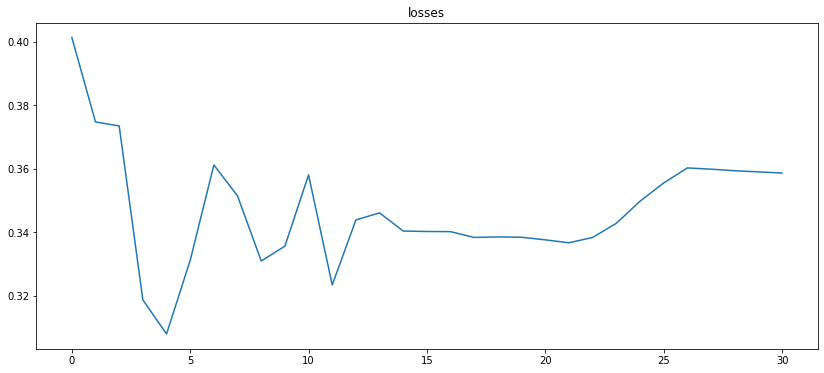

<Figure size 432x288 with 0 Axes>

In [188]:
plt.figure(figsize=(14, 6))
plt.plot(losses)

plt.title('losses')
plt.show()
plt.savefig('add_feat_3.png')

#### Train the model very well with all the datas


In [189]:
n,p = np.shape(tX_2)
w_2 = logistic_regression_ADAM(y ,tX_2, 0, 10000, np.zeros(p))

#### Reconstruct the x_test based on the model

In [190]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [196]:
model = model_2[:4]

In [197]:
#Now Build the tX train data set

#start with bias
tX_model_test = build_poly(tX_test[:,1],0,linear ='True')
tX_test = normalize(tX_test)
#create model
for feat, deg in model:
    feat = int(float(feat.item()))
    print(feat,deg)
    if deg == 'arctan':
        tX_model_test = np.append(tX_model_test, np.array([np.arctan(tX_test[:,feat])]).T,axis=1)
    elif deg == 'cos':
        tX_model_test = np.append(tX_model_test, np.array([np.cos(tX_test[:,feat])]).T,axis=1)
    elif deg =='sin':
        tX_model_test = np.append(tX_model_test, np.array([np.sin(tX_test[:,feat])]).T,axis=1)
    else :
        deg = float(deg)
        if deg == 0.5 or deg == 1/3 or deg == -1/2 or deg == -1/3:
            tX_model_test = np.append(tX_model_test, np.array([np.abs(tX_test[:,feat])**deg]).T,axis=1)
        elif deg != 0:
            tX_model_test = np.append(tX_model_test, np.array([tX_test[:,feat]**deg]).T,axis=1)
np.shape(tX_model_test)

0 0.0
0 1.0
1 1.0
2 1.0


(568238, 4)

In [199]:
OUTPUT_PATH = 'data/proj1_jo_add_feat_4.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w_2[:4], tX_model_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = 'data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = 'result/to_try.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, build_poly(tX_test,degree))
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)